In [1]:
import random
import datetime
import operator 
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import array
from datetime import timedelta


import folium
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot

#import plotly
#py.init_notebook_mode()
#import plotly.offline as py
#from fbprophet import Prophet
#import plotly.graph_objs as go
#from fbprophet.plot import plot_plotly

%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Reading the Data

In [ ]:
dataset = pd.read_csv('counties.csv')
#add_data = pd.read_csv('enriched_covid_19_week_2_us_1.csv')
add_data = pd.read_csv('enriched_covid_19_week_2_us_1.csv')
us_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
infections = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

today_date = datetime.datetime.strptime(confirmed_df.columns[-1],'%m/%d/%y').strftime("%m-%d-%Y")
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+today_date+'.csv')

# Feature Exploration Analysis

##### Preparing 2 datasets to merge together 1) time series cases/deaths + 2) features

In [3]:
len(dataset.columns.tolist()) #347 columns with state, counties names and features for USA
latest_temp = latest_data.loc[latest_data["Country_Region"]== "US"]
latest_temp = latest_temp.replace(np.nan, 0, regex=True)

In [4]:
list_counties_state=dataset['Area_Name'].unique()
list_of_states=us_states['state'].unique()

In [5]:
#Before merging datasets, need to make sure all the states are included
list_counties_state=dataset['Area_Name'].unique()
a=[]
b=[]
for i in list_of_states:
    if i in list_counties_state:
        a.append(i)
    else:
        b.append(i)
print('List of States in the couties dataset', a)
print('List of States NOT in the couties dataset', b)

List of States in the couties dataset ['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts', 'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida', 'New York', 'Rhode Island', 'Georgia', 'New Hampshire', 'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada', 'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota', 'Oklahoma', 'Pennsylvania', 'South Carolina', 'District of Columbia', 'Kansas', 'Missouri', 'Vermont', 'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan', 'South Dakota', 'Arkansas', 'Delaware', 'Mississippi', 'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine', 'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'West Virginia']
List of States NOT in the couties dataset ['Virgin Islands', 'Guam', 'Northern Mariana Islands']


In [6]:
#Removing states which is not in counties dataset
us_states_limited=us_states[us_states['state'].isin(a)]
us_states_limited.state.unique().shape #should be 52

(52,)

##### List of the features

In [7]:
# List of the features for exploration
for column in dataset.columns:
    print(column)

FIPS
State
Area_Name
Rural-urban_Continuum Code_2013
Urban_Influence_Code_2013
Economic_typology_2015
POP_ESTIMATE_2018
N_POP_CHG_2018
Births_2018
Deaths_2018
NATURAL_INC_2018
INTERNATIONAL_MIG_2018
DOMESTIC_MIG_2018
NET_MIG_2018
RESIDUAL_2018
GQ_ESTIMATES_2018
R_birth_2018
R_death_2018
R_NATURAL_INC_2018
R_INTERNATIONAL_MIG_2018
R_DOMESTIC_MIG_2018
R_NET_MIG_2018
Less than a high school diploma 2014-18
High school diploma only 2014-18
Some college or associate's degree 2014-18
Bachelor's degree or higher 2014-18
Percent of adults with less than a high school diploma 2014-18
Percent of adults with a high school diploma only 2014-18
Percent of adults completing some college or associate's degree 2014-18
Percent of adults with a bachelor's degree or higher 2014-18
POVALL_2018
CI90LBAll_2018
CI90UBALL_2018
PCTPOVALL_2018
CI90LBALLP_2018
CI90UBALLP_2018
POV017_2018
CI90LB017_2018
CI90UB017_2018
PCTPOV017_2018
CI90LB017P_2018
CI90UB017P_2018
POV517_2018
CI90LB517_2018
CI90UB517_2018
PCTPOV5

In [8]:
### After performing correlation for all the features, the following list was selected 
features_list=['Area_Name','POP_ESTIMATE_2018', 
               'Density per square mile of land area - Population', 
               "Percent of adults with a bachelor's degree or higher 2014-18", 
               'Active Physicians per 100000 Population 2018 (AAMC)', 
               "Percent of adults completing some college or associate's degree 2014-18", 
               'POVALL_2018',
              'Unemployment_rate_2018']
dataset_limited=dataset[features_list]
dataset_limited=dataset_limited[dataset_limited['Area_Name'].isin(a)]
dataset_limited.Area_Name.unique().shape #should be 52

(52,)

In [9]:
#Check if there is any missing data
nulls = pd.DataFrame(dataset_limited.isna().sum().sort_values(ascending=False)[:10])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

Null Count
Feature                                                       
POVALL_2018                                                  1
Active Physicians per 100000 Population 2018 (A...           1
Unemployment_rate_2018                                       0
Percent of adults completing some college or as...           0
Percent of adults with a bachelor's degree or h...           0
Density per square mile of land area - Population            0
POP_ESTIMATE_2018                                            0
Area_Name                                                    0

In [10]:
#Replacing missing data 
dataset_limited.fillna(dataset_limited.mean(), inplace=True)

##### Dataset df_merged - merged dataset timeseries + features

In [11]:
df_merged = pd.merge(us_states_limited, dataset_limited, how="inner", left_on='state', right_on='Area_Name')
# Dropping some features
df_merged.drop(['Area_Name', 'fips'], axis=1, inplace=True)
# Creating new features
df_merged['deaths rate per 100 000']=df_merged['deaths']*100000/df_merged['POP_ESTIMATE_2018']
df_merged['cases rate per 100 000']=df_merged['cases']*100000/df_merged['POP_ESTIMATE_2018']
df_merged.tail()

date          state  cases  deaths  POP_ESTIMATE_2018  \
4134  2020-05-14  West Virginia   1434      62            1805832   
4135  2020-05-15  West Virginia   1447      64            1805832   
4136  2020-05-16  West Virginia   1470      65            1805832   
4137  2020-05-17  West Virginia   1492      67            1805832   
4138  2020-05-18  West Virginia   1502      68            1805832   

      Density per square mile of land area - Population  \
4134                                               77.1   
4135                                               77.1   
4136                                               77.1   
4137                                               77.1   
4138                                               77.1   

      Percent of adults with a bachelor's degree or higher 2014-18  \
4134                                               20.3              
4135                                               20.3              
4136                                               20.3              
4137                                               20.3              
4138                                               20.3              

      Active Physicians per 100000 Population 2018 (AAMC)  \
4134                                              263.4     
4135                                              263.4     
4136                                              263.4     
4137                                              263.4     
4138                                              263.4     

      Percent of adults completing some college or associate's degree 2014-18  \
4134                                               25.7                         
4135                                               25.7                         
4136                                               25.7                         
4137                                               25.7                         
4138                                               25.7                         

      POVALL_2018  Unemployment_rate_2018  deaths rate per 100 000  \
4134     305656.0                     5.3                 3.433320   
4135     305656.0                     5.3                 3.544073   
4136     305656.0                     5.3                 3.599449   
4137     305656.0                     5.3                 3.710201   
4138     305656.0                     5.3                 3.765577   

      cases rate per 100 000  
4134               79.409380  
4135               80.129270  
4136               81.402921  
4137               82.621196  
4138               83.174958

##### Dataset df_merged_today - extracting only today's data into the dataframe 

In [12]:
df_merged_today=df_merged[df_merged['date']==df_merged['date'][len(df_merged)-1]]
df_merged_today.tail()

date          state  cases  deaths  POP_ESTIMATE_2018  \
3874  2020-05-18        Alabama  12086     489            4887871   
3941  2020-05-18          Idaho   2455      74            1754208   
4008  2020-05-18        Montana    470      16            1062305   
4075  2020-05-18    Puerto Rico   2710     124            3195153   
4138  2020-05-18  West Virginia   1502      68            1805832   

      Density per square mile of land area - Population  \
3874                                               94.4   
3941                                               19.0   
4008                                                6.8   
4075                                             1088.2   
4138                                               77.1   

      Percent of adults with a bachelor's degree or higher 2014-18  \
3874                                               24.9              
3941                                               26.9              
4008                                               31.2              
4075                                               25.3              
4138                                               20.3              

      Active Physicians per 100000 Population 2018 (AAMC)  \
3874                                         217.100000     
3941                                         192.600000     
4008                                         247.100000     
4075                                         293.244231     
4138                                         263.400000     

      Percent of adults completing some college or associate's degree 2014-18  \
3874                                               29.9                         
3941                                               35.9                         
4008                                               32.7                         
4075                                               22.3                         
4138                                               25.7                         

        POVALL_2018  Unemployment_rate_2018  deaths rate per 100 000  \
3874  801758.000000                     3.9                10.004356   
3941  201804.000000                     2.8                 4.218428   
4008  134185.000000                     3.7                 1.506159   
4075  806925.403846                     9.2                 3.880878   
4138  305656.000000                     5.3                 3.765577   

      cases rate per 100 000  
3874              247.265118  
3941              139.949196  
4008               44.243414  
4075               84.815970  
4138               83.174958

##### Dataset df_transit = metro + number of airports + tourist popularity
Preparing data from different additional sorces. Data in dataframe df_transit includes number of airports in each state, wheather state has a metro or not and rating of tourist popularity

In [13]:
list1=['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa','Kansas', 
       'Kentucky', 'Louisiana','Maine','Maryland', 'Massachusetts','Michigan','Minnesota','Mississippi',
      'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
      'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania' ,'Puerto Rico', 'Rhode Island',
      'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah','Vermont','Virgin Islands', 'Virginia', 
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia']

#Number of the airports in the States
# Data is taken from Wikipedia https://en.wikipedia.org/wiki/List_of_airports_in_the_United_States
list2=[5,27,1,9,4,22,9,2,1,20,7,1,7,6,11,4,5,4,5,7,4,3,6,15,8,3,5,
       8,3,5,3,3,4,16,10,6,3,8,3,4,9,7,3,6,3,5,24,5,1,2,8,10,4,8,6,4]

# Rating of the most popular visitors states, where 0 is the least popular, 51 is the most popular
# Data is from https://www.businessinsider.com/the-most-popular-us-states-for-tourism-2014-10?r=US&IR=T
list_most_visited=[38,18,0,44,7,51,36,10,14,
                  50,43,0,42,13,34,28,10,16,
                  19,23,8,26,31,21,29,25,
                  22,12,3,49,4,35,15,47,32,
                   9,0,40,11,24,30,0,5,
                  45,16,41,48,37,2,0,46,
                  27,1,33,27,39]

# List of the states which have metro
# Data is takes from "American Public Transportation Organisation" https://www.apta.com
list_states_with_metro=['California', 'New York', 'District of Columbia', 'Illinois', 'Massachusetts', 'Pennsylvania', 'Georgia',
                        'Florida' , 'Maryland' , 'Ohio', 'Puerto Rico']

data = {'state': list1, 'n_airports': list2, 'most_visited':list_most_visited, 'metro': 0}
df_transit=pd.DataFrame.from_dict(data)
df_transit['metro'] = df_transit['state'].isin(list_states_with_metro).astype(int)

df_merged_today = pd.merge(df_merged_today, df_transit, how="inner", left_on='state', right_on='state')
df_merged_today=df_merged_today.drop(29)
df_merged_today=df_merged_today.reset_index(drop=True)
df_merged_today.tail()

date          state  cases  deaths  POP_ESTIMATE_2018  \
47  2020-05-18        Alabama  12086     489            4887871   
48  2020-05-18          Idaho   2455      74            1754208   
49  2020-05-18        Montana    470      16            1062305   
50  2020-05-18    Puerto Rico   2710     124            3195153   
51  2020-05-18  West Virginia   1502      68            1805832   

    Density per square mile of land area - Population  \
47                                               94.4   
48                                               19.0   
49                                                6.8   
50                                             1088.2   
51                                               77.1   

    Percent of adults with a bachelor's degree or higher 2014-18  \
47                                               24.9              
48                                               26.9              
49                                               31.2              
50                                               25.3              
51                                               20.3              

    Active Physicians per 100000 Population 2018 (AAMC)  \
47                                         217.100000     
48                                         192.600000     
49                                         247.100000     
50                                         293.244231     
51                                         263.400000     

    Percent of adults completing some college or associate's degree 2014-18  \
47                                               29.9                         
48                                               35.9                         
49                                               32.7                         
50                                               22.3                         
51                                               25.7                         

      POVALL_2018  Unemployment_rate_2018  deaths rate per 100 000  \
47  801758.000000                     3.9                10.004356   
48  201804.000000                     2.8                 4.218428   
49  134185.000000                     3.7                 1.506159   
50  806925.403846                     9.2                 3.880878   
51  305656.000000                     5.3                 3.765577   

    cases rate per 100 000  n_airports  most_visited  metro  
47              247.265118           5            38      0  
48              139.949196           6            13      0  
49               44.243414           8            12      0  
50               84.815970           7             0      1  
51               83.174958           4             1      0

##### Correlation analysis of most important features

In [14]:
data_corr = df_merged_today.select_dtypes(include=[np.number])
corr = data_corr.corr()
corr

cases    deaths  \
cases                                               1.000000  0.983965   
deaths                                              0.983965  1.000000   
POP_ESTIMATE_2018                                   0.522784  0.405914   
Density per square mile of land area - Population   0.020764  0.029331   
Percent of adults with a bachelor's degree or h...  0.248618  0.230437   
Active Physicians per 100000 Population 2018 (A...  0.182600  0.198970   
Percent of adults completing some college or as... -0.358746 -0.342039   
POVALL_2018                                         0.490730  0.379515   
Unemployment_rate_2018                              0.028602  0.041439   
deaths rate per 100 000                             0.788007  0.816168   
cases rate per 100 000                              0.714622  0.720362   
n_airports                                          0.329785  0.262546   
most_visited                                        0.376229  0.296759   
metro                                               0.461307  0.395189   

                                                    POP_ESTIMATE_2018  \
cases                                                        0.522784   
deaths                                                       0.405914   
POP_ESTIMATE_2018                                            1.000000   
Density per square mile of land area - Population           -0.083598   
Percent of adults with a bachelor's degree or h...           0.051915   
Active Physicians per 100000 Population 2018 (A...          -0.043150   
Percent of adults completing some college or as...          -0.157021   
POVALL_2018                                                  0.988134   
Unemployment_rate_2018                                       0.034037   
deaths rate per 100 000                                      0.169585   
cases rate per 100 000                                       0.107212   
n_airports                                                   0.702683   
most_visited                                                 0.607269   
metro                                                        0.490274   

                                                    Density per square mile of land area - Population  \
cases                                                                                        0.020764   
deaths                                                                                       0.029331   
POP_ESTIMATE_2018                                                                           -0.083598   
Density per square mile of land area - Population                                            1.000000   
Percent of adults with a bachelor's degree or h...                                           0.647341   
Active Physicians per 100000 Population 2018 (A...                                           0.879598   
Percent of adults completing some college or as...                                          -0.594551   
POVALL_2018                                                                                 -0.083339   
Unemployment_rate_2018                                                                       0.276232   
deaths rate per 100 000                                                                      0.286738   
cases rate per 100 000                                                                       0.351332   
n_airports                                                                                  -0.098547   
most_visited                                                                                 0.115948   
metro                                                                                        0.346648   

                                                    Percent of adults with a bachelor's degree or higher 2014-18  \
cases                                                                                        0.248618              
deaths                                  

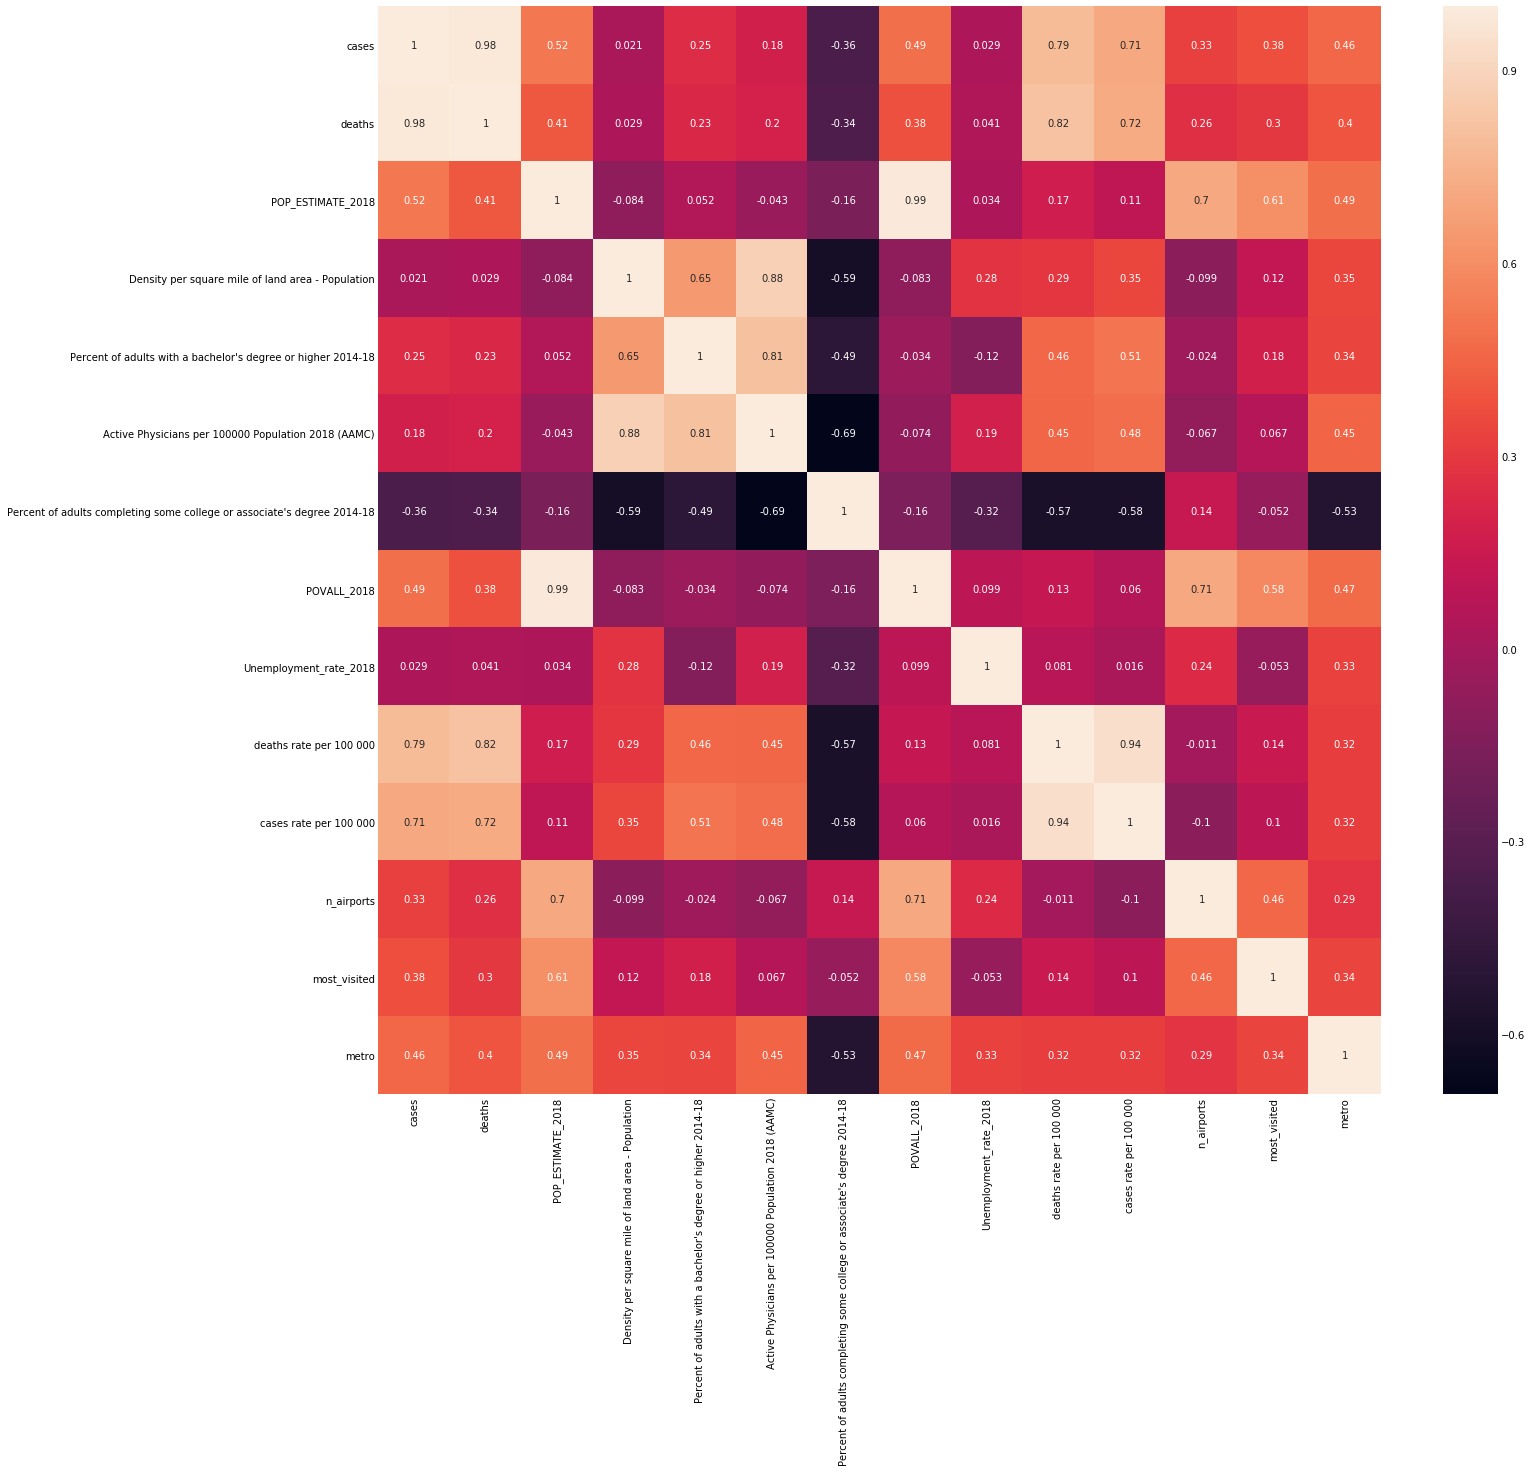

In [15]:
fig, ax = plt.subplots(figsize=(20,20))         
sns.heatmap(corr, annot=True)
plt.show()

##### Have a closer look into correlation analysis

In [16]:
def show_corr_matrix(df_merged_today, features_list,sort_by_feature):
    mat=df_merged_today[features_list]
    correlation_mat = mat.corr()
    correlation_mat.sort_values(sort_by_feature, ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(5,5))         
    sns.heatmap(correlation_mat, annot=True)
    plt.show()

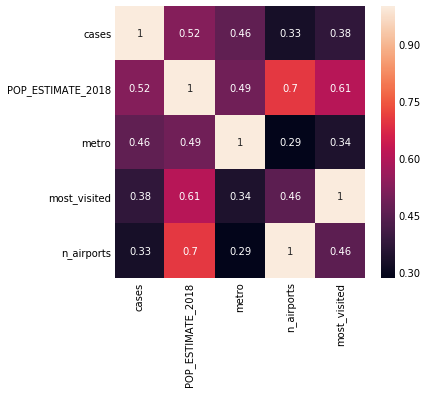

In [17]:
sort_by_feature=['cases']
features_list=['cases','POP_ESTIMATE_2018','metro','n_airports', 'most_visited']
show_corr_matrix(df_merged_today, features_list, sort_by_feature)

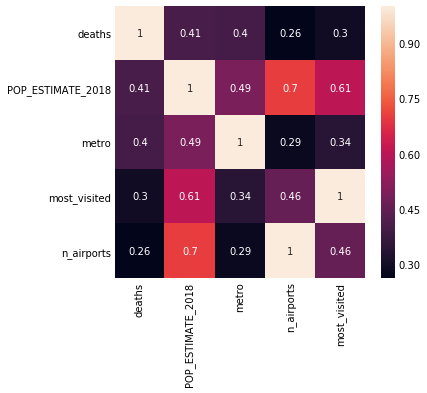

In [18]:
sort_by_feature=['deaths']
features_list=['deaths','POP_ESTIMATE_2018','metro','n_airports', 'most_visited']
show_corr_matrix(df_merged_today, features_list, sort_by_feature)

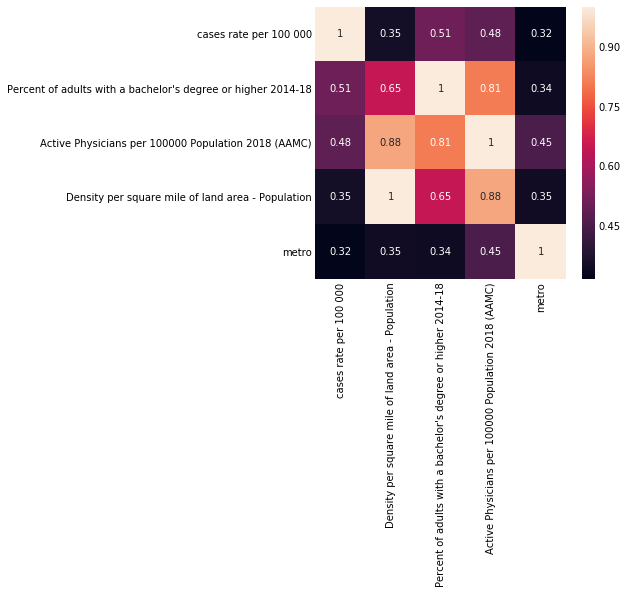

In [19]:
sort_by_feature=["cases rate per 100 000"]
features_list=["cases rate per 100 000", "Density per square mile of land area - Population","Percent of adults with a bachelor's degree or higher 2014-18", "Active Physicians per 100000 Population 2018 (AAMC)", "metro"]
show_corr_matrix(df_merged_today, features_list,sort_by_feature)

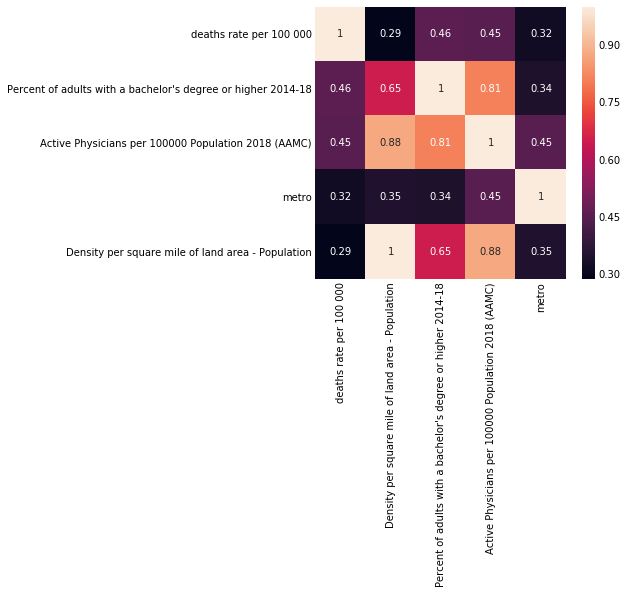

In [20]:
sort_by_feature=["deaths rate per 100 000"]
features_list=["deaths rate per 100 000", "Density per square mile of land area - Population","Percent of adults with a bachelor's degree or higher 2014-18", "Active Physicians per 100000 Population 2018 (AAMC)", "metro"]
show_corr_matrix(df_merged_today, features_list,sort_by_feature)

# 1.Visualization of Data

### 1.1 Interactive Map

The map shows number of cases and states for each state

In [21]:
# Plotting number of cases in USA
latest_temp = latest_data.loc[latest_data["Country_Region"]== "US"]
latest_temp = latest_temp.replace(np.nan, 0, regex=True)
usa = folium.Map(location=[37, -102], zoom_start=4,max_zoom=8,min_zoom=4)
for i in np.int32(np.asarray(latest_temp[latest_temp['Confirmed'] > 0].index)):
    folium.Circle(
        location=[latest_temp.loc[i]['Lat'], latest_temp.loc[i]['Long_']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+latest_temp.loc[i]['Province_State']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(latest_temp.loc[i]['Country_Region']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(latest_temp.loc[i]['Confirmed'])+"</li>"+
        "<li>Active:   "+str(latest_temp.loc[i]['Active'])+"</li>"+
        "<li>Recovered:   "+str(latest_temp.loc[i]['Recovered'])+"</li>"+       
        "<li>Deaths:   "+str(latest_temp.loc[i]['Deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(latest_temp.loc[i]['Deaths']/(latest_temp.loc[i]['Confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=int((np.log2(latest_temp.loc[i]['Confirmed']+1))*6000),
        color='#c40814',
        fill_color='#f2666f',
        fill=True).add_to(usa)

usa
#usa.save('usa.html')

### 1.2 Map of number of Confirmed Cases

In [22]:
USA_location = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json').json()
data_plot = latest_temp.groupby(["Province_State"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_plot["Confirmed_log"] = np.log10(data_plot["Confirmed"]+1)
data_plot["Deaths_log"] = np.log10(data_plot["Deaths"]+1)
bins = list(data_plot['Confirmed_log'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=6,min_zoom=3)
 
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=USA_location,
    name='choropleth',
    data = data_plot,
    columns=['Province_State', 'Confirmed_log'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = bins,
    reset=True,
    legend_name='Confirmed cases log (10^x)'
).add_to(m)
folium.LayerControl().add_to(m)

legend_html = "<div style='padding:10px;background-color:rgba(255,255,255,0.5);position:fixed;bottom:20px;left:20px;z-index:1000'>"
legend_html += "<div style='width:100%;text-align:center;'><h4>Index for Legend</h4></div><hr style='border-top-color: rgba(25,25,25,0.5);'>"
legend_html += "<ul style='margin:0;padding:0;color: #555;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"
for i in bins:
    legend_html += "<li style='margin:0;padding:0;line-height: 0;'>Value "+str(np.round(i,2))+" : "+str(int(10**i)-1)+"</li><br>"
legend_html += "</ul></div>"
m.get_root().html.add_child(folium.Element(legend_html))
m

### 1.3 Map of number of Confirmed Deaths

In [23]:
data_plot = latest_temp.groupby(["Province_State"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_plot["Confirmed_log"] = np.log10(data_plot["Confirmed"]+1)
data_plot["Deaths_log"] = np.log10(data_plot["Deaths"]+1)
bins = list(data_plot['Deaths_log'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=6,min_zoom=3)
 
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=USA_location,
    name='choropleth',
    data = data_plot,
    columns=['Province_State', 'Deaths_log'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = bins,
    reset=True,
    legend_name='Deaths cases log (10^x)'
).add_to(m)
folium.LayerControl().add_to(m)

legend_html = "<div style='padding:10px;background-color:rgba(255,255,255,0.5);position:fixed;bottom:20px;left:20px;z-index:1000'>"
legend_html += "<div style='width:100%;text-align:center;'><h4>Index for Legend</h4></div><hr style='border-top-color: rgba(25,25,25,0.5);'>"
legend_html += "<ul style='margin:0;padding:0;color: #555;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"
for i in bins:
    legend_html += "<li style='margin:0;padding:0;line-height: 0;'>Value "+str(np.round(i,2))+" : "+str(int(10**i)-1)+"</li><br>"
legend_html += "</ul></div>"
m.get_root().html.add_child(folium.Element(legend_html))
m

### 1.4 The Order of States with number of cases/deaths decreasing

In [24]:
#Most effected States in USA
latest_temp.loc[:,["Confirmed","Deaths","Province_State"]].groupby(["Province_State"]).sum().sort_values("Confirmed",ascending=False).style.background_gradient(cmap='Reds',subset=["Confirmed"]).background_gradient(cmap='Greys',subset=["Deaths"])

### 1.5 The line plot of TimeSeries data per States

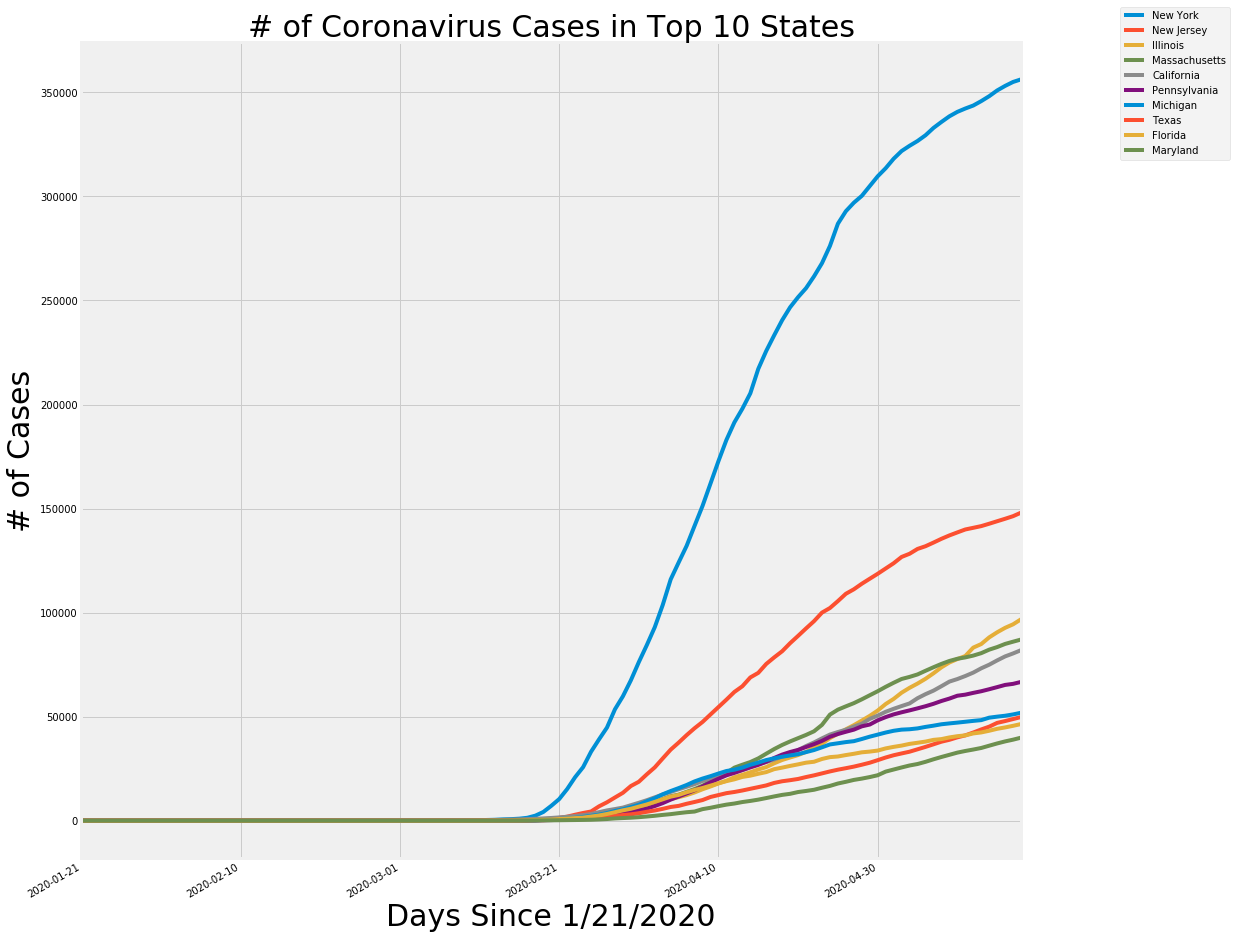

In [25]:
# Top 10 Most affected States in USA
top_10_states=latest_temp.loc[:,["Confirmed","Deaths","Province_State"]].groupby(["Province_State"]).sum().sort_values("Confirmed",ascending=False)
top_10_states=list(top_10_states[:10].index.get_level_values(0))

list_states=us_states.state.unique()
min_date=us_states.date.min()
fig, ax = plt.subplots(figsize=(15,15))

for i in top_10_states:
    us_states_temp=us_states[us_states.state==i]
    us_states_temp=us_states_temp.drop(["fips"],axis=1)


    if us_states_temp.date.min()>min_date: #2020-01-24'
        new_add_dates = pd.date_range(start=min_date, end=us_states_temp.date.min()).sort_values(ascending=True)[0:-1]
        new_append_list = []
        for dt in new_add_dates:
            new_append_list.append([dt.strftime("%Y-%m-%d"), 'Illinois', 0, 0])
        new_dates = pd.DataFrame(
            new_append_list,
            columns = ["date", "state", "cases", "deaths"])
        us_states_temp_extended = pd.concat([us_states_temp, new_dates]).sort_values(by='date')

    us_states_temp_extended.plot(ax=ax, x='date', y='cases', label=i, kind = 'line')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('# of Coronavirus Cases in Top 10 States', size=30)
plt.xlabel('Days Since 1/21/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.show()


### 1.6 The Pie-Chart of Cases per States

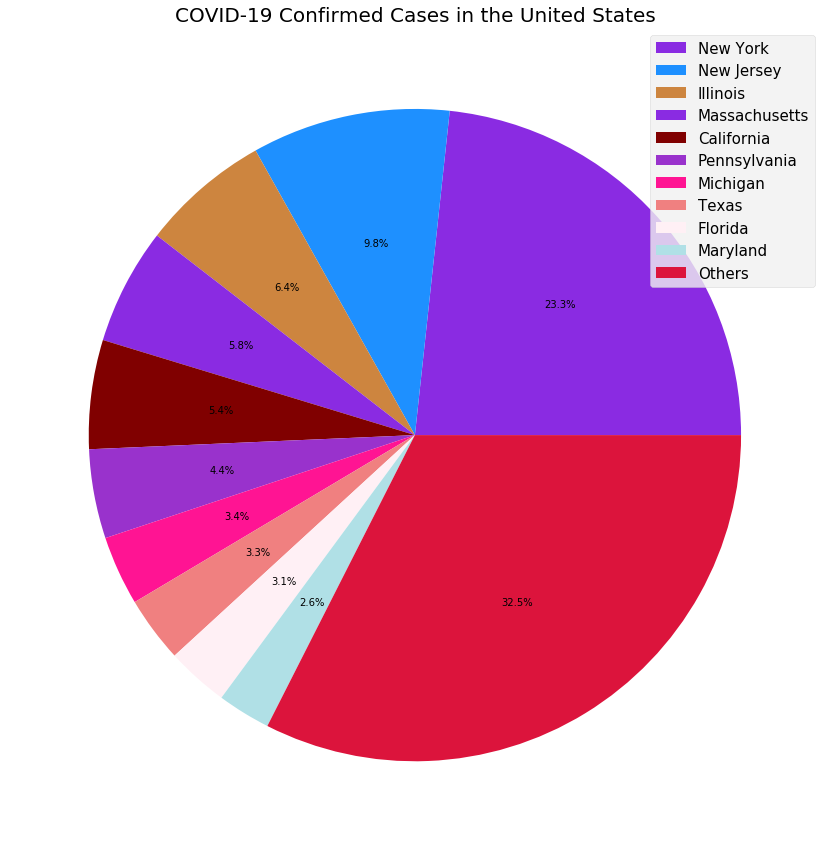

In [26]:
# Plotting the regional data using a pie chart. 
unique_countries =  list(latest_data['Country_Region'].unique())
unique_provinces =  list(latest_data['Province_State'].unique())
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)


for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

def plot_pie_charts(x, y, title):
    c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c, autopct='%1.1f%%')
    plt.legend(x, loc='best', fontsize=15)
    plt.show()

def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 10 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>10):
        regions_10 = regions[:10]
        regions_10.append('Others')
        confirmed_cases_10 = confirmed_cases[:10]
        confirmed_cases_10.append(np.sum(confirmed_cases[10:]))
        plot_pie_charts(regions_10,confirmed_cases_10, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

plot_pie_country_with_regions('US', 'COVID-19 Confirmed Cases in the United States')

# 2.Forecasting Timeseries Data

### 2.1 TimeSeries Data Exploration

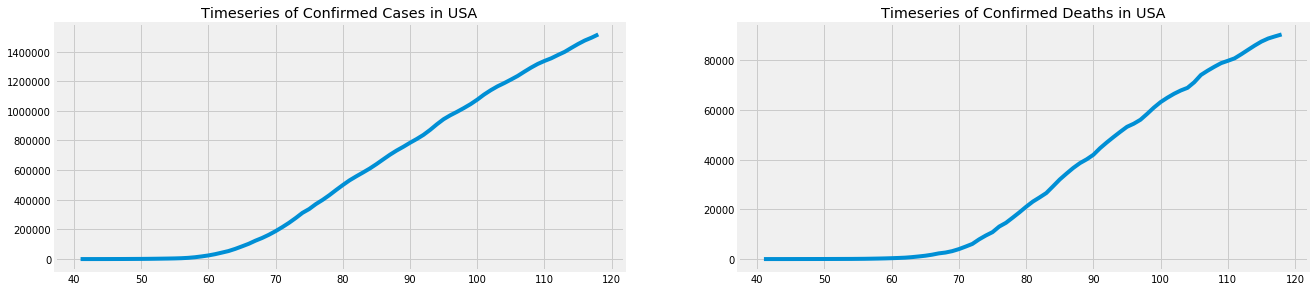

In [27]:
data = infections.groupby('date', as_index=False).agg({"cases": "sum", 
                                             "deaths": "sum"})
data_new = data[data['cases']>100]

cases = data_new.cases
deaths = data_new.deaths

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(cases)
ax1.title.set_text('Timeseries of Confirmed Cases in USA')
ax2.plot(deaths)
ax2.title.set_text('Timeseries of Confirmed Deaths in USA')

Before trying to make predictions, we are checking whether is there relationships between the lags. In case if there is no relation, there is no point in forecasting the time series based on the lags

c:\users\user\desktop\ds\g6\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
c:\users\user\desktop\ds\g6\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


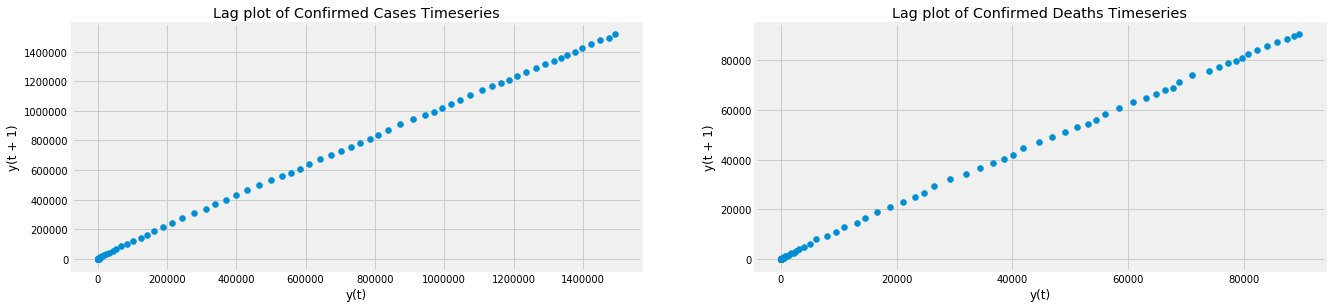

In [28]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

plt.subplot(221)
lag_plot(cases)

plt.subplot(222)
lag_plot(deaths)

ax1.title.set_text('Lag plot of Confirmed Cases Timeseries')
ax2.title.set_text('Lag plot of Confirmed Deaths Timeseries')

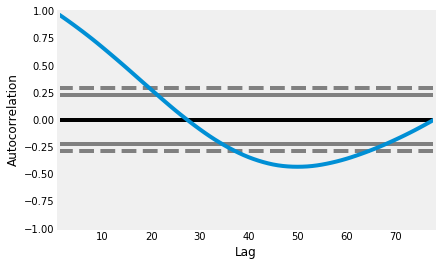

In [29]:
autocorrelation_plot(cases)

This plot shows lag along the x-axis and the correlation on the y-axis. The correlation values above the Dotted lines indicate that these correlations are statistically significant.

Both of these plots show a strong positive correlation between observations and their lag values. This tells us that the data has a shape and we can try to model it

### 2.2 Preparing the Data

In [30]:
dataframe_cases = pd.concat([cases.shift(1), cases], axis=1)
dataframe_deaths = pd.concat([deaths.shift(1), deaths], axis=1)
dataframe_cases.columns = ['t', 't+1']
dataframe_deaths.columns = ['t', 't+1']

# split into train and test sets
X_cases = dataframe_cases.values
X_deaths = dataframe_deaths.values

train_size = int(len(X_cases) * 0.8)
train_cases, test_cases = X_cases[1:train_size], X_cases[train_size:]
train_deaths, test_deaths = X_deaths[1:train_size], X_deaths[train_size:]

#cases
train_X_cases, train_y_cases = train_cases[:,0], train_cases[:,1]
test_X_cases, test_y_cases = test_cases[:,0], test_cases[:,1]
train_X_cases = train_X_cases.reshape(-1, 1)
test_X_cases = test_X_cases.reshape(-1, 1)
train_y_cases = train_y_cases.reshape(-1, 1)
test_y_cases = test_y_cases.reshape(-1, 1)


#deaths
train_X_deaths, train_y_deaths = train_deaths[:,0], train_deaths[:,1]
test_X_deaths, test_y_deaths = test_deaths[:,0], test_deaths[:,1]
train_X_deaths = train_X_deaths.reshape(-1, 1)
train_y_deaths = train_y_deaths.reshape(-1, 1)
test_X_deaths = test_X_deaths.reshape(-1, 1)
test_y_deaths = test_y_deaths.reshape(-1, 1)

### 2.3 Persistence Model

In order to check the performance of the models we are going to train, we will write a basic algorithm, called the persistance algorithm, which will be used as a baseline.

In [31]:
# persistence model
def model_persistence(x):
    return x

# walk-forward validation for cases
cases_predictions = list()
for x in test_X_cases:
    yhat = model_persistence(x)
    cases_predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y_cases, cases_predictions))
print('Test RMSE: %.3f' % rmse)


# walk-forward validation for deaths
deaths_predictions = list()
for x in test_X_deaths:
    yhat = model_persistence(x)
    deaths_predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y_deaths, deaths_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23724.457
Test RMSE: 1585.243


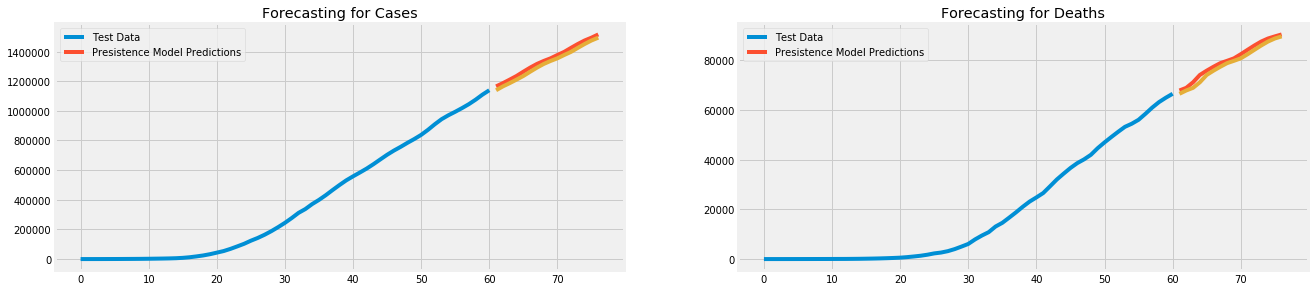

In [32]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)


# plot predictions and expected results for cases
ax1.plot(train_y_cases)
ax1.plot([None for i in train_y_cases] + [x for x in test_y_cases])
ax1.plot([None for i in train_y_cases] + [x for x in cases_predictions])
ax1.legend(['Test Data', 'Presistence Model Predictions'])
ax1.title.set_text('Forecasting for Cases')

# plot predictions and expected results for deaths
ax2.plot(train_y_deaths)
ax2.plot([None for i in train_y_deaths] + [x for x in test_y_deaths])
ax2.plot([None for i in train_y_deaths] + [x for x in deaths_predictions])
ax2.legend(['Test Data', 'Presistence Model Predictions'])
ax2.title.set_text('Forecasting for Deaths')

Now after having the most basic model, we will try different statistical and machine learning algorithms to obtain the best predictor.

First we will try statistical methods to predict the time series data, after, we will explore the correlation between the different features and cases per each state, and use our findings to fit more complicated ML Algorithms.

### 2.4 Linear Regression Model

In [33]:
# linear regression
linear_model_cases = LinearRegression(normalize=True, fit_intercept=True)
linear_model_cases.fit(train_X_cases, train_y_cases)

# predicting
linear_pred_cases = linear_model_cases.predict(test_X_cases)

#checking the performance
rmse = np.sqrt(mean_squared_error(test_y_cases, linear_pred_cases))
print('Test RMSE: %.3f' % rmse)


# linear regression
linear_model_deaths = LinearRegression(normalize=True, fit_intercept=True)
linear_model_deaths.fit(train_X_deaths, train_y_deaths)

# predicting
linear_pred_deaths = linear_model_deaths.predict(test_X_deaths)

#checking the performance
rmse = np.sqrt(mean_squared_error(test_y_deaths, linear_pred_deaths))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 21716.731
Test RMSE: 1890.093


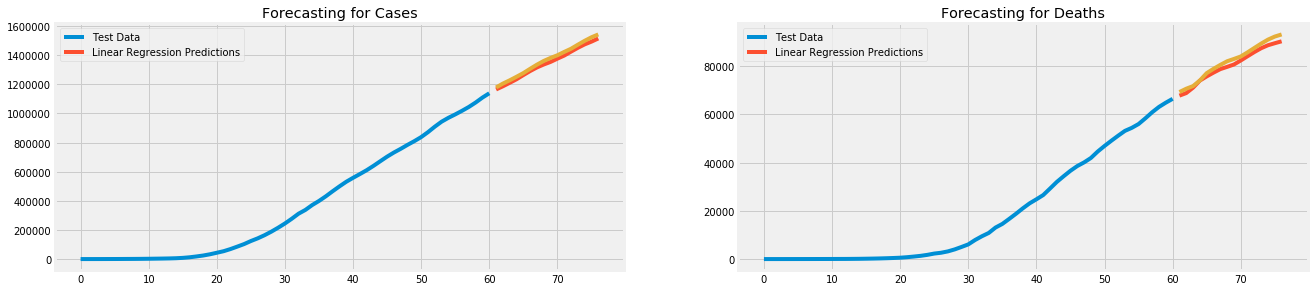

In [34]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)


# plot predictions and expected results for cases
ax1.plot(train_y_cases)
ax1.plot([None for i in train_y_cases] + [x for x in test_y_cases])
ax1.plot([None for i in train_y_cases] + [x for x in linear_pred_cases])
ax1.legend(['Test Data', 'Linear Regression Predictions'])
ax1.title.set_text('Forecasting for Cases')

# plot predictions and expected results for deaths
ax2.plot(train_y_deaths)
ax2.plot([None for i in train_y_deaths] + [x for x in test_y_deaths])
ax2.plot([None for i in train_y_deaths] + [x for x in linear_pred_deaths])
ax2.legend(['Test Data', 'Linear Regression Predictions'])
ax2.title.set_text('Forecasting for Deaths')

### 2.5 SVM Model

In [35]:
# SVM model for cases
svm_cases = SVR(shrinking=True, kernel='linear',gamma=0.01, epsilon=0.01, degree=3, C=0.01)
svm_cases.fit(train_X_cases, train_y_cases)

# predicting
svm_pred_cases = svm_cases.predict(test_X_cases)

#checking the performance
rmse = np.sqrt(mean_squared_error(test_y_cases, svm_pred_cases))
print('Test RMSE: %.3f' % rmse)



# SVM model for deaths
svm_deaths = SVR(shrinking=True, kernel='linear',gamma=0.01, epsilon=0.01, degree=3, C=0.01)
svm_deaths.fit(train_X_deaths, train_y_deaths)

# predicting
svm_pred_deaths = svm_deaths.predict(test_X_deaths)

#checking the performance
rmse = np.sqrt(mean_squared_error(test_y_deaths, svm_pred_deaths))
print('Test RMSE: %.3f' % rmse)

c:\users\user\desktop\ds\g6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test RMSE: 22267.806
Test RMSE: 1996.334


c:\users\user\desktop\ds\g6\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


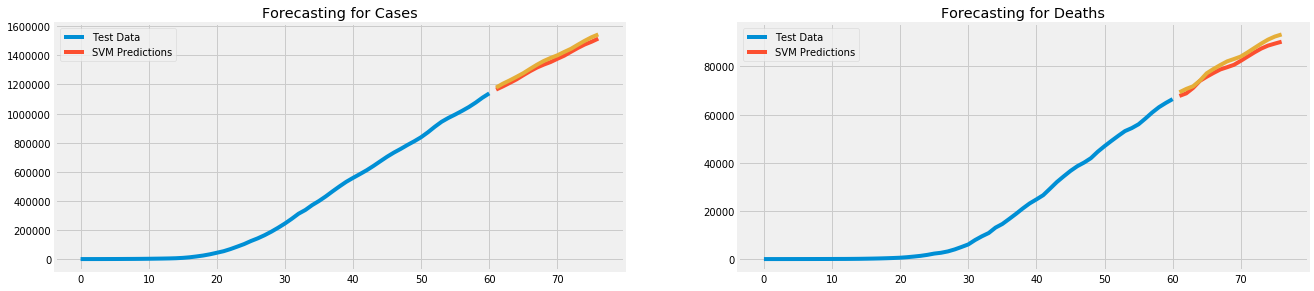

In [36]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)


# plot predictions and expected results for cases
ax1.plot(train_y_cases)
ax1.plot([None for i in train_y_cases] + [x for x in test_y_cases])
ax1.plot([None for i in train_y_cases] + [x for x in svm_pred_cases])
ax1.legend(['Test Data', 'SVM Predictions'])
ax1.title.set_text('Forecasting for Cases')

# plot predictions and expected results for deaths
ax2.plot(train_y_deaths)
ax2.plot([None for i in train_y_deaths] + [x for x in test_y_deaths])
ax2.plot([None for i in train_y_deaths] + [x for x in svm_pred_deaths])
ax2.legend(['Test Data', 'SVM Predictions'])
ax2.title.set_text('Forecasting for Deaths')

### 2.6 Prophet Model

In [37]:
list_of_states=us_states.state.unique()
print(list_of_states)

['Washington' 'Illinois' 'California' 'Arizona' 'Massachusetts'
 'Wisconsin' 'Texas' 'Nebraska' 'Utah' 'Oregon' 'Florida' 'New York'
 'Rhode Island' 'Georgia' 'New Hampshire' 'North Carolina' 'New Jersey'
 'Colorado' 'Maryland' 'Nevada' 'Tennessee' 'Hawaii' 'Indiana' 'Kentucky'
 'Minnesota' 'Oklahoma' 'Pennsylvania' 'South Carolina'
 'District of Columbia' 'Kansas' 'Missouri' 'Vermont' 'Virginia'
 'Connecticut' 'Iowa' 'Louisiana' 'Ohio' 'Michigan' 'South Dakota'
 'Arkansas' 'Delaware' 'Mississippi' 'New Mexico' 'North Dakota' 'Wyoming'
 'Alaska' 'Maine' 'Alabama' 'Idaho' 'Montana' 'Puerto Rico'
 'Virgin Islands' 'Guam' 'West Virginia' 'Northern Mariana Islands']


In [38]:
# Prepare data - choose state and deaths or cases 
def prepare_data_for_model(us_states, state_name, cases_deaths):
    us_states_temp=us_states[us_states.state==state_name]
    columns_used=["date", cases_deaths ]
    us_states_temp=us_states_temp[columns_used]
    return us_states_temp

### Data preparation

In [ ]:
# Select state for prediction model and also cases or deaths to be predicted
cases_deaths="cases"
state_name="California"

#Prepare dataframe for Prophet model
us_states_temp=prepare_data_for_model(us_states, state_name, cases_deaths)
us_states_temp.columns=['ds', 'y']
us_states_temp.tail()
us_states_temp_train=us_states_temp[:-10]
us_states_temp_test=us_states_temp[-10:]

### Building the model and predict

In [ ]:
m=Prophet(interval_width=0.95)
m.fit(us_states_temp_train)
all_dates=m.make_future_dataframe(periods=10)
prediction=m.predict(all_dates)
prediction[['ds', 'yhat']].tail(5)

### Plot real vs. predicted

In [ ]:
#Plotting prediction with Prophet
figure = plot_plotly(m, prediction)
py.iplot(figure) 
figure = m.plot(prediction, xlabel='Date',ylabel='# Confirmed '+cases_deaths+" in "+state_name)

In [ ]:
#Plotting prediction with Prophet vs Real
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(us_states_temp['ds'],
        us_states_temp['y'],
        label='Real')
ax.plot(us_states_temp['ds'],
        prediction['yhat'],
        label='Predicted')
# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="# Confirmed "+cases_deaths+" in "+state_name,
       title="Prophet model Predicted vs Real "+cases_deaths+" in "+state_name)

# plt.axvline(x = TRAIN_SPLIT, linewidth=3, ls = ':',color='black', label="Train-test split")
ax.set_xticks(ax.get_xticks()[::5])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

### Model evaluation

In [ ]:
#Model evaluation MAE
from sklearn.metrics import mean_absolute_error 
print( 'Mean absolute error of Prophet model is', mean_absolute_error(us_states_temp_test['y'], prediction['yhat'][-10:]))

#Model evaluation MSE
from sklearn.metrics import mean_squared_error
print( 'Mean squared error of Prophet model is', mean_squared_error(us_states_temp_test['y'], prediction['yhat'][-10:]))

#Model evaluation RMSE
from sklearn.metrics import mean_squared_error
print( 'RMSE of Prophet model is', mean_squared_error(us_states_temp_test['y'], prediction['yhat'][-10:], squared=False))

### 2.7 MLP Model

In [39]:
# Funcrion for plotting regression model
def plot_prediction_regression(days, dataset, prediction, TEST_SIZE, cases_deaths, state_name):
    TRAIN_SPLIT=len(dataset)-TEST_SIZE
    days=list(days)
    dataset=list(dataset)
    prediction=list(prediction)
    plt.figure(figsize=(10, 10))
    line1=plt.plot(days, dataset,label="Real")
    line2=plt.plot(days, prediction, label="Forecasted")
    line3=plt.axvline(x = TRAIN_SPLIT, linewidth=3, ls = ':',color='black', label="Train-test split")
    plt.title(" Regression model Predicted vs Real "+cases_deaths+" in "+state_name)
    plt.ylabel("Confirmed Cases")
    plt.xlabel("Days")
    plt.legend()

### Data preparation

In [40]:
# Select state for prediction model and also cases or deaths to be predicted
cases_deaths="cases"
state_name="California"
TEST_SIZE=10 #10 days left for testing
us_states_temp=prepare_data_for_model(us_states, state_name, cases_deaths)
us_states_temp_train=us_states_temp[:-TEST_SIZE]
us_states_temp_test=us_states_temp[-TEST_SIZE:]
TRAIN_SPLIT=len(us_states_temp)-TEST_SIZE

x_train = np.arange(len(us_states_temp_train)).reshape(-1, 1)
y_train = us_states_temp_train[cases_deaths].values
x_test = np.arange(len(us_states_temp)).reshape(-1, 1)
y_test = us_states_temp[cases_deaths].values
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(105, 1) (105,)
(115, 1) (115,)


### Building the model and predict

In [41]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=32)
_=model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred = y_pred.round().astype(int)

### Plot real vs. predicted

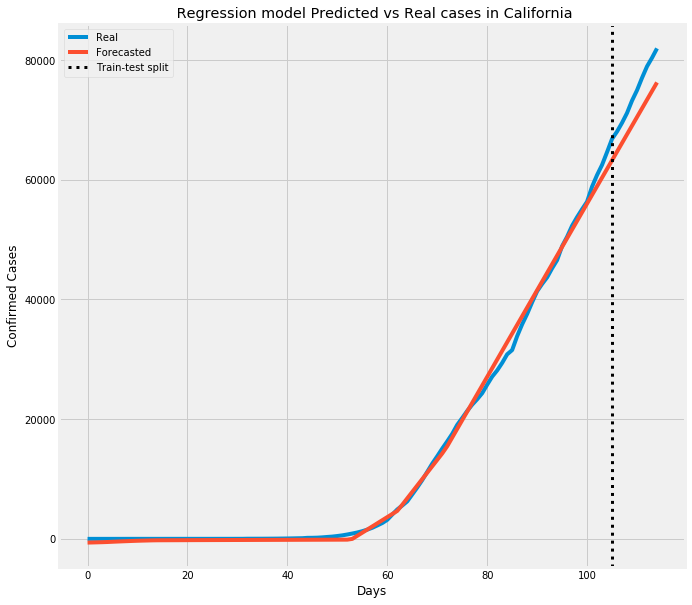

In [42]:
plot_prediction_regression(x_test, y_test, y_pred, TEST_SIZE, cases_deaths, state_name)

### Model evaluation

In [43]:
#Model Evaluation
y_pred_10=y_pred[-TEST_SIZE:]
y_test_10=y_test[-TEST_SIZE:]

from sklearn.metrics import mean_absolute_error 
print( 'Mean absolute error of MLP model is', mean_absolute_error(y_pred_10, y_test_10))

#Model evaluation MSE
from sklearn.metrics import mean_squared_error
print( 'Mean squared error of MLP model is', mean_squared_error(y_pred_10, y_test_10))

#Model evaluation RMSE
#from sklearn.metrics import mean_squared_error
#print( 'RMSE of MLP model is', mean_squared_error(y_pred_10, y_test_10, squared=False))

Mean absolute error of MLP model is 4444.3
Mean squared error of MLP model is 20590378.5


### 2.8 LSTM Model

In [44]:
# Function for plotting regression model
def plot_prediction_LSTM(days, dataset, prediction, Country, TRAIN_SPLIT):
    plt.figure(figsize=(10, 6))
    line1=plt.plot(days, dataset,label="Real")
    line2=plt.plot(days, prediction, label="Forecasted")
    line3=plt.axvline(x = TRAIN_SPLIT, linewidth=3, ls = ':',color='black', label="Train-test split")
    plt.title(Country+" Single Neuron Forecasting")
    plt.ylabel("Confirmed Cases")
    plt.xlabel("Days")
    plt.legend()

### Data preparation

In [45]:
# Select state for prediction model and also cases or deaths to be predicted
cases_deaths="cases"
state_name="California"
TEST_SIZE=10 #10 days left for testing
num_steps = 2
window_size = 2
num_features = 1

us_states_temp=prepare_data_for_model(us_states, state_name, cases_deaths)
us_states_temp_train=us_states_temp[:-TEST_SIZE]
us_states_temp_test=us_states_temp[-TEST_SIZE:]
TRAIN_SPLIT=len(us_states_temp)-TEST_SIZE

x_train = list(np.arange(len(us_states_temp_train)).reshape(-1, 1))
y_train = list(us_states_temp_train[cases_deaths].values)

x_test = list(np.arange(len(us_states_temp)).reshape(-1, 1))
y_test = list(us_states_temp[cases_deaths].values)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

105 105
115 115


### Building the model and predict

In [46]:
# split a sequence into samples
def split_sequence(sequence, num_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + num_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 

X, y = split_sequence(y_train, num_steps)
X = X.reshape((X.shape[0], X.shape[1], num_features))

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(num_steps, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
model.fit(X, y, epochs=1000, verbose=0)

forecast=[]
y_pred_10=[]
for time in range(len(x_test) - window_size):
    x_input=array(y_test[time:time + window_size])
    x_input=x_input.reshape((1, num_steps, num_features))
    forecast.append(model.predict(x_input))
    y_pred_10.append(model.predict(x_input)[0,0])
print('type forecast', len(forecast))  
y_pred_10=y_pred_10[TRAIN_SPLIT-window_size:]
forecast = forecast[TRAIN_SPLIT-window_size:]
print('len forecast', len(forecast))
results = np.array(forecast)[:, 0, 0]
print('shape forecast', len(forecast))
pred=y_train+y_pred_10
print('shape pred', len(pred))

type forecast 113
len forecast 10
shape forecast 10
shape pred 115


### Plot real vs. predicted

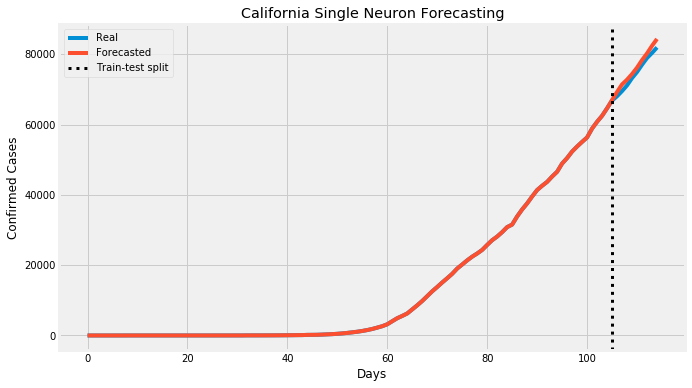

In [47]:
plot_prediction_LSTM(x_test, y_test, pred, state_name, TRAIN_SPLIT)

### Model evaluation

In [48]:
#Model Evaluation
y_pred_10=pred[-TEST_SIZE:]
y_test_10=y_test[-TEST_SIZE:]

from sklearn.metrics import mean_absolute_error 
print( 'Mean absolute error of Prophet model is', mean_absolute_error(y_pred_10, y_test_10))

#Model evaluation MSE
from sklearn.metrics import mean_squared_error
print( 'Mean squared error of Prophet model is', mean_squared_error(y_pred_10, y_test_10))

#Model evaluation RMSE
#from sklearn.metrics import mean_squared_error
#print( 'RMSE of Prophet model is', mean_squared_error(y_pred_10, y_test_10, squared=False))

Mean absolute error of Prophet model is 1432.75703125
Mean squared error of Prophet model is 2394781.1093933107


# 3. Sequential LSTM for TimeSeries Forecasting with Feautures


### 3.1 Exploration of Features, which will be included in LSTM model. Finding the Correlation - Heatmap

In [49]:
corr_data_1 = add_data[add_data['Province_State'] == 'Washington'][['Province_State', 'POP_ESTIMATE_2018',
                                                                   'Density', 'restrictions', 'quarantine', 
                                                                   'schools', 'n_airports', 'metro', 
                                                                   'ConfirmedCases', 'Fatalities']]
corr_data_1.head()

NameError: name 'add_data' is not defined

In [50]:
corr_data_2 = add_data.groupby('Province_State', as_index=False).agg({"POP_ESTIMATE_2018": pd.Series.mode, 
                                             "Density": pd.Series.mode,
                                            "n_airports" : pd.Series.mode,
                                            "metro" : pd.Series.mode,
                                            "ConfirmedCases" : pd.Series.max,
                                            "Fatalities" : pd.Series.max})

dumm = pd.get_dummies(corr_data_2.metro, prefix = 'metro')
corr_data_2 = corr_data_2.join(dumm, how = 'left')
corr_data_2 = corr_data_2[['Province_State', 'POP_ESTIMATE_2018', 'Density', 'n_airports', 'metro', 'metro_0', 'metro_1', 
                          'ConfirmedCases', 'Fatalities']]
corr_data_2.head()

NameError: name 'add_data' is not defined

In [ ]:
corr_matrix_1_cases = corr_data_1[corr_data_1.columns[1:10]].corr()['ConfirmedCases'][:].abs()
corr_matrix_1_deaths = corr_data_1[corr_data_1.columns[1:10]].corr()['Fatalities'][:].abs()

corr_matrix_2_cases = corr_data_2[corr_data_2.columns[1:9]].corr()['ConfirmedCases'][:].abs()
corr_matrix_2_deaths = corr_data_2[corr_data_2.columns[1:9]].corr()['Fatalities'][:].abs()
corr_matrix_1_cases.sort_values()

In [ ]:
corr_matrix_1_deaths.sort_values()

In [ ]:
corr_matrix_2_cases.sort_values().tail(10)

In [ ]:
corr_matrix_2_deaths.sort_values().tail(10)

In [ ]:
sns.heatmap(corr_data_2[corr_data_2.columns[1:9]].corr())

### 3.2 Sequential LSTM for TimeSeries Forecasting with Feautures

### Preparing the Data

In [ ]:
infections = add_data[['Province_State', 'Date', 'ConfirmedCases', 'Density', 'Fatalities', 'restrictions', 'schools']]

In [ ]:
infections['Date'] = pd.to_datetime(infections.Date , format = '%m/%d/%Y')
#infections.drop(['deaths'], axis = 1, inplace = True)

list0 = list(infections[(infections['Date'] == '2020-03-17') & (infections['ConfirmedCases'] >= 1)]['Province_State'])

#infections[(infections['Date'] == '2020-03-25') & (infections['ConfirmedCases'] >= 100)]
len(list0)

In [ ]:
list1 = list(infections[(infections['Date'] == '2020-03-17') & (infections['ConfirmedCases'] >= 1)]['Province_State'])
n_df_cases = infections[(infections['Date'] > '2020-03-17') & (infections['Province_State'].isin(list1))]

n_df_cases.reset_index(inplace = True)
#n_df_cases.dropna(inplace = True)
#n_df_cases.drop(['index', 'county', 'state'], axis = 1, inplace = True)

#density = dataset[['FIPS', 'Area_Name','Density per square mile of land area - Population']]
#test = density.merge(n_df_cases, how = 'left', left_on = 'FIPS', right_on = 'fips')
test = n_df_cases
test.dropna(inplace = True)
test.drop(['index'], axis = 1, inplace = True)

test_test = test.pivot_table(index=['Date'],
                                columns='Province_State',
                                fill_value=0).swaplevel(axis = 1).sort_index(1)
#test_test_density = test.drop('cases', axis = 1)
#test_test_density = test_test_density.pivot_table(index=['date'],
                                #columns='FIPS',
                                #fill_value=0).swaplevel(axis = 1).sort_index(1)

test_test.tail()

In [ ]:
test_test.head()

### Building the model

In [ ]:
del model

In [ ]:
# Setting the target county
target_county = 'New York'

# and target feature.
target_names = ['ConfirmedCases']

# Shifting the target data 1 steps forward for model to learn.
shift_days = 1
shift_steps = shift_days 
df_targets = test_test[target_county][target_names].shift(-shift_steps)

In [ ]:
x_data = test_test.values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]

# Splitting the data to train/test.
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

# Scaling the data.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
def batch_generator(batch_size, sequence_length):

    while True:
        # Allocating a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocating a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Filling the batch with random sequences of data.
        for i in range(batch_size):
            # Getting a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copying the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
# Setting the batch size
batch_size = 50
# and sequence length
sequence_length = 7 * 4 # for 4 weeks of observations

In [ ]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [ ]:
x_batch, y_batch = next(generator)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
model = Sequential()

model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

init = RandomUniform(minval=-0.05, maxval=0.05)
model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

optimizer = RMSprop(lr=1e-3)

In [ ]:
# Setting the warmup steps for model
warmup_steps = 1

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse


model.compile(loss=loss_mse_warmup, optimizer=optimizer)

model.summary()

In [ ]:
'''path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]'''

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
# Training the model
model.fit(x=generator,
          epochs=5,
          steps_per_epoch=50,
          validation_data=validation_data,
          callbacks=callbacks)

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [ ]:
plot_comparison(start_idx=0, length=24, train=False)

In [ ]:
# Checking the Predicted and True Values
x_true = x_test_scaled
y_true = y_test
x = np.expand_dims(x_true, axis=0)
y_pred = model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
true = pd.DataFrame(y_true, columns = ['True'])
predicted = pd.DataFrame(y_pred_rescaled, columns = ['Predicted'])
df_lstm = pd.concat([true,predicted], axis = 1)
df_lstm

In [ ]:
plt.plot(y_train)
plt.plot([None for i in y_train] + [x for x in y_test])
plt.plot([None for i in y_train] + [x for x in y_pred_rescaled])
plt.legend(['Test Data', 'LSTM Predictions'])

In [ ]:
#checking the performance
rmse = np.sqrt(mean_squared_error(y_true, y_pred_rescaled))
print('Test RMSE: %.3f' % rmse)

### 3.3 Functional Model for Forecasting

### Preparing the Data

In [ ]:
add_data['Date'] = pd.to_datetime(add_data['Date'], format='%Y%m%d')

In [ ]:
add_data['Date'].dtype

In [ ]:
add_data['Date'] = add_data['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
add_data['Date'].dtype

In [ ]:
add_data.head()

In [ ]:
dummies = pd.get_dummies(add_data['metro'], prefix = 'metro')

In [ ]:
extra_data_df = add_data.join(dummies, how = 'left')

In [ ]:
extra_data_df.drop(['Id', 'region', 'metro'], axis =1, inplace = True)
extra_data_df.head()

In [ ]:
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]

extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["POP_ESTIMATE_2018"].astype("float")
extra_data_df["density"] = extra_data_df["Density"].astype("float")
extra_data_df["n_airports"] = extra_data_df["n_airports"].astype("int")

extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["n_airports"] = extra_data_df["n_airports"]/max(extra_data_df["n_airports"])

extra_data_df = extra_data_df[["Province_State","Country_Region","Date","ConfirmedCases", "Fatalities","restrictions","quarantine","schools","n_airports","total_pop","density"]]
extra_data_df.head()

In [ ]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [ ]:
add_data['Date'].dtype

In [ ]:
train_df = extra_data_df.query("Date>'2020-01-22'and Date<'2020-04-01'")

In [ ]:
days_in_sequence = 21
for country in train_df.Country_Region.unique():
    for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
        province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
        for i in range(0,len(province_df),int(days_in_sequence/3)):
            print(len(province_df))

In [ ]:
#Just getting rid of the first days to have a multiple of 7
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]
                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    n_airports = float(province_df.iloc[i].n_airports)
                
                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)
                    
                    
                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,n_airports],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)


In [ ]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [ ]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<0:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [ ]:
sequence_length = 20
training_percentage = 0.9

In [ ]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [ ]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [ ]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

### Building the Model

In [ ]:
del model

In [ ]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(3))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)

model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [ ]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
predictions = model.predict([X_temporal_test,X_demographic_test])

In [ ]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    #print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

### Predicting

In [ ]:
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=20)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)), (1,0) ).astype(np.float32)
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    n_airports = float(province_df.iloc[i].n_airports)
    demographic_input_data = [total_population,density,n_airports]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [ ]:
from datetime import datetime
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-04-01"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "n_airports": input_data[1][0][2],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [ ]:
#The functions that are called here need to optimise, sorry about that!
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

In [ ]:
groundtruth_df = gpd.read_file("train.csv")
groundtruth_df = groundtruth_df[groundtruth_df['Country_Region'] == 'US']

groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe.
groundtruth_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in groundtruth_df.iterrows()]

last_date = groundtruth_df.Date.unique()[-1]

In [ ]:
pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(region, groundtruth_df, display_only=False):
    groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
    groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
    
    #we only take data until the 30th of March 2020 as the groundtruth was not available for later dates.
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    predictions = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.ConfirmedCases.values, predictions.ConfirmedCases.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.Fatalities.values, predictions.Fatalities.values ))
    if display_only:
        print(region)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [ ]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for region in groundtruth_df.Country_Region.unique():
        if region == 'US_Guam' or region == 'US_Virgin Islands':
            pass
        else:
            RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(region, groundtruth_df, False)
            RMSLE_cases_list.append(RMSLE_cases)
            RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

In [ ]:
get_RMSLE_for_all_regions(groundtruth_df)

In [ ]:
def display_comparison(region,groundtruth_df):   
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

In [ ]:
display_comparison("US_Alabama", groundtruth_df)

In [ ]:
def display_long_term_prediction(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-05-14'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

In [ ]:
display_long_term_prediction("US_Washington", groundtruth_df)

### 3.4 Predicting the cumulative number of cases based on features

### Data Preparation

In [ ]:
corr_data = corr_data_2.drop('metro', axis = 1)

corr_data.head()

In [ ]:
X = corr_data[['POP_ESTIMATE_2018', 'Density', 'n_airports', 'metro_0', 'metro_1']].values
y = corr_data[['ConfirmedCases']].values

In [ ]:
X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(X, y, test_size=0.1, random_state=0)

### Building the Model - SVM

In [ ]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_cases, y_train_cases)
test_linear_pred = linear_model.predict(X_test_cases)


print('MAE:', mean_absolute_error(test_linear_pred, y_test_cases))
print('MSE:',mean_squared_error(test_linear_pred, y_test_cases))
print('КMSE:',np.sqrt(mean_squared_error(test_linear_pred, y_test_cases)))

In [ ]:
y_test_cases

In [ ]:
test_linear_pred

In [ ]:
plt.plot(y_test_cases)
plt.plot(test_linear_pred)
plt.legend(['Test Data: First 30', 'Polynomial Regression Predictions: First 30'])

# 4. Predicting cumulative number of cases/deaths based on features

In [27]:
df_merged_today.tail()

date          state  cases  deaths  POP_ESTIMATE_2018  \
47  2020-05-17        Alabama  11771     488            4887871   
48  2020-05-17          Idaho   2421      73            1754208   
49  2020-05-17        Montana    468      16            1062305   
50  2020-05-17    Puerto Rico   2646     123            3195153   
51  2020-05-17  West Virginia   1492      67            1805832   

    Density per square mile of land area - Population  \
47                                               94.4   
48                                               19.0   
49                                                6.8   
50                                             1088.2   
51                                               77.1   

    Percent of adults with a bachelor's degree or higher 2014-18  \
47                                               24.9              
48                                               26.9              
49                                               31.2              
50                                               25.3              
51                                               20.3              

    Active Physicians per 100000 Population 2018 (AAMC)  \
47                                         217.100000     
48                                         192.600000     
49                                         247.100000     
50                                         293.244231     
51                                         263.400000     

    Percent of adults completing some college or associate's degree 2014-18  \
47                                               29.9                         
48                                               35.9                         
49                                               32.7                         
50                                               22.3                         
51                                               25.7                         

      POVALL_2018  Unemployment_rate_2018  deaths rate per 100 000  \
47  801758.000000                     3.9                 9.983897   
48  201804.000000                     2.8                 4.161422   
49  134185.000000                     3.7                 1.506159   
50  806925.403846                     9.2                 3.849581   
51  305656.000000                     5.3                 3.710201   

    cases rate per 100 000  n_airports  most_visited  metro  
47              240.820594           5            38      0  
48              138.011000           6            13      0  
49               44.055144           8            12      0  
50               82.812936           7             0      1  
51               82.621196           4             1      0

In [28]:
list_most_correlated=['POP_ESTIMATE_2018','metro','n_airports', 'most_visited']
X=df_merged_today[list_most_correlated]
y=df_merged_today['cases']

   cases     predicted
0    754   6088.975535
1   4759   8190.557816
2  94362  72069.254643
3  51054  24741.053166
4  11069  21001.858392
5   8067  10695.211476
Rmse of linear model is 14917.240534746583


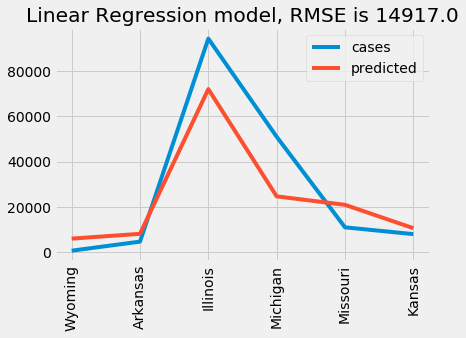

In [29]:
# Building Regression Model for cases/deaths
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=33)
list_index=X_test.index
list_index=df_merged_today.iloc[list_index]['state'].tolist()

regr.fit(X_train, y_train)
y_pred=regr.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

#Predicting Regression model for cases/deaths
df_prediction=pd.DataFrame(data=y_test, columns=['cases'])
df_prediction['predicted']=(y_pred)
df_prediction.reset_index(drop=True, inplace=True)
print(df_prediction)
print('Rmse of linear model is', test_set_rmse)

#Plotting model prediction vs real
plt.title("Linear Regression model, RMSE is "+str(round(test_set_rmse)))
x = np.array([0,1,2,3,4,5])
my_xticks = list_index
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(df_prediction)
plt.legend(df_prediction.columns,loc='upper right')
plt.show()

Rmse of Decision tree model is 18188.289167300296
   cases  predicted
0    754      468.0
1   4759    10348.0
2  94362    65745.0
3  51054    18537.0
4  11069    19598.0
5   8067     5938.0


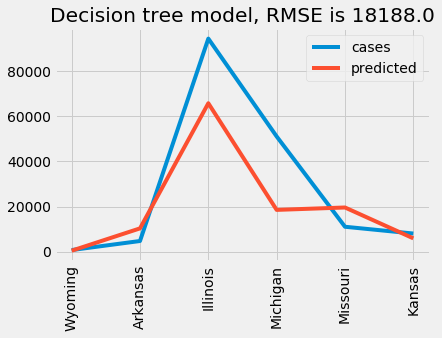

In [31]:
# Building Decision tree for cases/deaths

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print('Rmse of Decision tree model is', test_set_rmse)

#Predict model
df_prediction=pd.DataFrame(data=y_test, columns=['cases'])
df_prediction['predicted']=(y_pred)
df_prediction.reset_index(drop=True, inplace=True)
print(df_prediction)

plt.title("Decision tree model, RMSE is "+str(round(test_set_rmse)))
x = np.array([0,1,2,3,4,5])
my_xticks = list_index
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(df_prediction)
plt.legend(df_prediction.columns,loc='upper right')
plt.show()